# Importando as bibliotecas:

In [ ]:
# Importando utilitários
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Importando libs para processamento de texto:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Baixndo os recursos necessários da nlkt:
nltk.download('stopwords')
# Baixndo os recursos necessários da nlkt:
nltk.download('punkt')

# Importando utilitários para o treino
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Verifica se a GPU está disponível
if tf.test.gpu_device_name():
    print('GPU encontrada:', tf.test.gpu_device_name())
else:
    print("Nenhuma GPU disponível, utilizando CPU.")

GPU encontrada: /device:GPU:0


# Carregando o dataset:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

caminho_dataset = '/content/drive/MyDrive/emotions.csv'

dataset = pd.read_csv(caminho_dataset)

# Exibindo as primeiras linhas do DataFrame para verificar se foi carregado corretamente
print(dataset.head())

Mounted at /content/drive
   Unnamed: 0                                               text  label
0           0      i just feel really helpless and heavy hearted      4
1           1  ive enjoyed being able to slouch about relax a...      0
2           2  i gave up my internship with the dmrg and am f...      4
3           3                         i dont know i feel so lost      0
4           4  i am a kindergarten teacher and i am thoroughl...      4


In [ ]:
# Informações sobre o tipo de dados:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  416809 non-null  int64 
 1   text        416809 non-null  object
 2   label       416809 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.5+ MB


In [ ]:
# Removendo a coluna 'Unnamed: 0' pois não precisamos dela
dataset = dataset.drop('Unnamed: 0', axis=1)

print(dataset.head())

                                                text  label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


In [ ]:
# buscando por duplicatas:
print(dataset.duplicated().sum())
print()

# removendo as duplicatas:
dataset = dataset.drop_duplicates()

# buscando novamente:
print(dataset.duplicated().sum())

686

0


In [ ]:
# Observando o formato:
print(f'O formato do dataframe é : {dataset.shape}')

O formato do dataframe é : (416123, 2)


# Análise dos Dados:


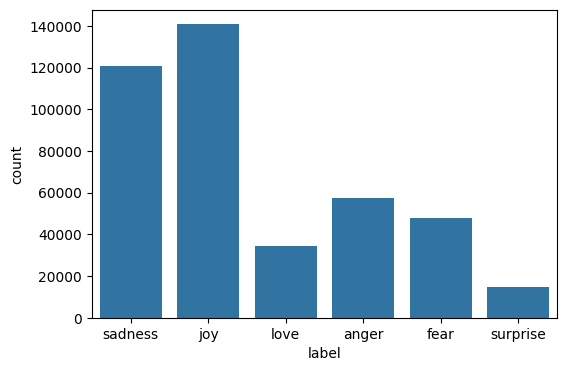

In [ ]:
classes = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

# Verificando o balanceamento das labels:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=dataset)
plt.xticks(ticks=range(len(classes)), labels=[classes[i] for i in range(len(classes))])
plt.show()

# Removendo chat words e stop_words:

In [ ]:
# Definindo um dicionário de palavras de chat:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My Ass Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The Ass",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My Ass Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The Fuck",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [ ]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def pre_proc(text):
    words =  re.findall(r'[a-zA-Z]+', text)
    words = [palavra for palavra in words if not palavra.lower() in stop_words]

    for i, word in enumerate(words):
        if word.upper() in chat_words:
          words[i] = chat_words[word.upper()].lower()
    return ' '.join(words)

dataset['text'] = dataset['text'].apply(pre_proc)

In [ ]:
print(dataset.head())

                                                text  label
0                 feel really helpless heavy hearted      4
1  ive enjoyed able slouch relax unwind frankly n...      0
2            gave internship dmrg feeling distraught      4
3                                dont know feel lost      0
4  kindergarten teacher thoroughly weary job take...      4


# Processando para valores:

In [ ]:
# Dividindo entre dados de treino e teste:
X_train, X_test, y_train, y_test = train_test_split(dataset['text'], dataset['label'], test_size=0.2, random_state=42)

# Printando os formatos dos conjuntos:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (332898,)
X_test shape: (83225,)
y_train shape: (332898,)
y_test shape: (83225,)


In [ ]:
X_train

153295    shed one tear couldnt help feel sentimental li...
184453                   feel becoming bitter way dont like
159598    feel top world last days feeling lethargic lik...
69800        feel honored privilege admire lys amazing work
102490    feel useless like running somehow defined running
                                ...                        
259471                    really feel like caring five kids
366388         feel many many partners work really talented
132015    manage make feel like idiot though remove moth...
146969    know one reading feel need sentimental dear br...
122033                      especially start feeling shitty
Name: text, Length: 332898, dtype: object

In [ ]:
y_train

153295    0
184453    3
159598    0
69800     1
102490    0
         ..
259471    2
366388    1
132015    0
146969    0
122033    0
Name: label, Length: 332898, dtype: int64

In [ ]:
# Criando um dicionário, definindo tamanho e conjuntos base:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

# Tokenizando os textos:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train_sequences[:5]

[[2513,
  13,
  2430,
  317,
  47,
  1,
  613,
  9,
  444,
  2104,
  1172,
  1093,
  197,
  173,
  22,
  1778,
  1823],
 [1, 848, 392, 22, 26, 3],
 [1, 659, 83, 70, 66, 2, 494, 3, 917, 7771, 20350, 596, 6915],
 [1, 543, 3260, 2384, 40520, 130, 42],
 [1, 358, 3, 411, 470, 5624, 411]]

In [ ]:
# Achando a frase com maior número de tokens:
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 79


In [ ]:
# Performando padding para deixar todas as "frases" com o mesmo tamanho:
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post',)
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

# Printando os conjuntos processados com o padding:
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[2513   13 2430 ...    0    0    0]
 [   1  848  392 ...    0    0    0]
 [   1  659   83 ...    0    0    0]
 ...
 [1456   24    1 ...    0    0    0]
 [   6   13  262 ...    0    0    0]
 [ 171  102    2 ...    0    0    0]]

X_test_padded:
[[   6  214  146 ...    0    0    0]
 [   2  223   32 ...    0    0    0]
 [ 190   11    1 ...    0    0    0]
 ...
 [   1  563 1100 ...    0    0    0]
 [   4  303 8710 ...    0    0    0]
 [   1    3  105 ...    0    0    0]]


In [ ]:
# Tamanho do vocabulário: (para saber o número de nós na entrada do modelo de embeddings)
input_Size = np.max(X_train_padded) + 1
input_Size

50000

# Definindo o nosso modelo:

In [ ]:
# Definindo o tipo de modelo:
model = Sequential()

# Adicionando um camada de embeddings
model.add(Embedding(input_dim=input_Size, output_dim=100, input_length=maxlen))

# Adicionando dropout ao modelo
model.add(Dropout(0.5))

# Adicionando uma camada bidirecional LSTM
model.add(Bidirectional(LSTM(128)))

# Aplicando uma normalização nos lotes de saida da camada anterior
model.add(BatchNormalization())

# Adicionando dropout ao modelo
model.add(Dropout(0.5))

# Adicionando uma camada densa com 64 nós e ativação relu
model.add(Dense(64, activation='relu'))

# Adicionando dropout ao modelo
model.add(Dropout(0.5))

# Adicionando uma camada de saída com a ativação softmax
model.add(Dense(6, activation='softmax'))

# Compilando o modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Printando o resumo do modelo
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 79, 100)           5000000   
                                                                 
 dropout_15 (Dropout)        (None, 79, 100)           0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 256)               234496    
 onal)                                                           
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 64)               

# Treinando e avaliando o modelo:

In [ ]:
# Treinando o modelo:
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=256, validation_data=(X_test_padded, y_test),callbacks=[EarlyStopping(patience=3)])

Epoch 1/5
1301/1301 [==============================] - 74s 53ms/step - loss: 0.4407 - accuracy: 0.8396 - val_loss: 0.3919 - val_accuracy: 0.8528
Epoch 2/5
1301/1301 [==============================] - 38s 29ms/step - loss: 0.1848 - accuracy: 0.9129 - val_loss: 0.2442 - val_accuracy: 0.9078
Epoch 3/5
1301/1301 [==============================] - 36s 28ms/step - loss: 0.1377 - accuracy: 0.9283 - val_loss: 0.1536 - val_accuracy: 0.9231
Epoch 4/5
1301/1301 [==============================] - 32s 25ms/step - loss: 0.1139 - accuracy: 0.9356 - val_loss: 0.1188 - val_accuracy: 0.9367
Epoch 5/5
1301/1301 [==============================] - 39s 30ms/step - loss: 0.1017 - accuracy: 0.9390 - val_loss: 0.0990 - val_accuracy: 0.9379


In [ ]:
# Avaliando o modelo no conjunto de teste:
model.evaluate(X_test_padded, y_test)

2601/2601 [==============================] - 19s 7ms/step - loss: 0.0990 - accuracy: 0.9379


[0.09899421781301498, 0.9379032850265503]

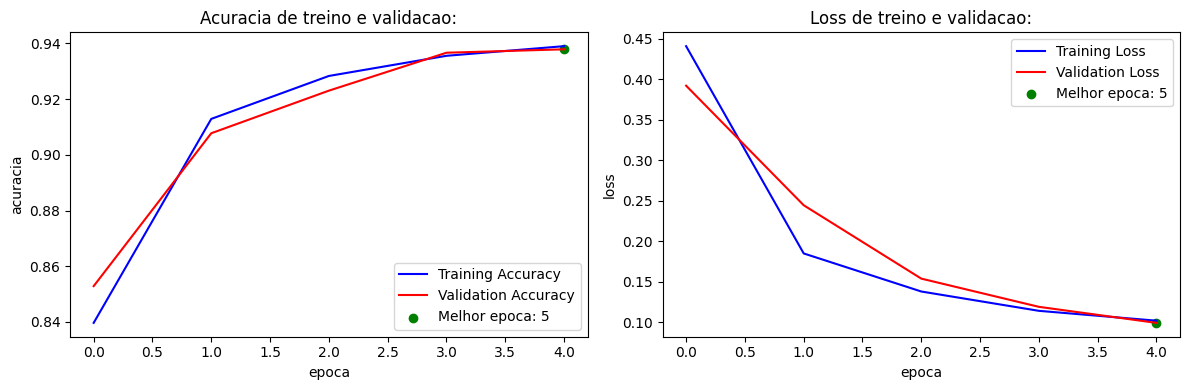

In [ ]:
# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Criando subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plotando a acurácia
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Melhor epoca: {best_epoch}')
axs[0].set_xlabel('epoca')
axs[0].set_ylabel('acuracia')
axs[0].set_title('Acuracia de treino e validacao:')
axs[0].legend()


# Plotando a loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Melhor epoca: {best_epoch}')
axs[1].set_xlabel('epoca')
axs[1].set_ylabel('loss')
axs[1].set_title('Loss de treino e validacao:')
axs[1].legend()

plt.tight_layout()
plt.show()

# Matriz de confusão:

2601/2601 [==============================] - 26s 10ms/step


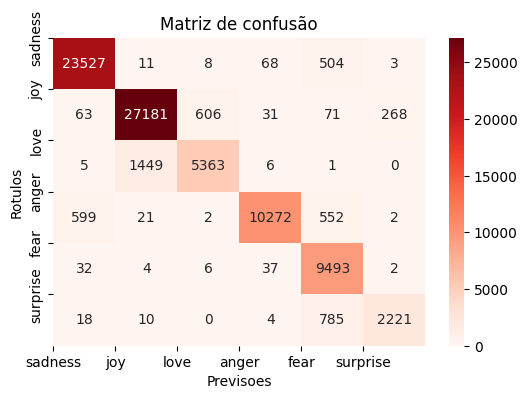

In [ ]:
# Predictions On Test For Confustion Matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)

# Plot da matriz de confusão com rótulos de classe
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')

# Definindo os rótulos dos eixos x e y
plt.xlabel('Previsoes')
plt.ylabel('Rotulos')
plt.xticks(ticks=np.arange(len(classes)), labels=[classes[i] for i in range(len(classes))])
plt.yticks(ticks=np.arange(len(classes)), labels=[classes[i] for i in range(len(classes))])
plt.title('Matriz de confusão')
plt.show()

# Realizando predições em tempo real:

In [ ]:
while True:
  mensagem = str(input("O que você deseja compartilhar? \n"))

  if(mensagem == "sair"):
    print("Até mais!")
    break

  else:
    mensagem = pre_proc(mensagem)
    mensagem = tokenizer.texts_to_sequences([mensagem])
    mensagem = pad_sequences(mensagem, maxlen=maxlen, padding='post',)
    predicao = model.predict(mensagem)
    predicao = np.argmax(predicao, axis=1)
    print(f"A classe prevista para sua mensagem foi: {classes[predicao[0]]}")


O que você deseja compartilhar? 
sair
Até mais!


# Salvando e carregando o modelo:

In [ ]:
# Salvando o modelo treinado:
model.save('/content/drive/MyDrive/modelo_emotions.keras')

In [ ]:
from tensorflow.keras.models import load_model

# Carregando o modelo
modelo_carregado = load_model('/content/drive/MyDrive/modelo_emotions.keras')

# Printando o resumo do modelo
modelo_carregado.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 79, 100)           5000000   
                                                                 
 dropout_15 (Dropout)        (None, 79, 100)           0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 256)               234496    
 onal)                                                           
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 64)               